In [1]:
# ! pip uninstall /Path/to/the/whl/file/torchlogic-0.0.1-py3-none-any.whl -y

In [2]:
# ! pip install /Path/to/the/whl/file/torchlogic-0.0.1-py3-none-any.whl

In [3]:
# ! pip install optuna

In [40]:
import warnings
warnings.filterwarnings("ignore", message="Choices for a categorical distribution should be a tuple")
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended")
warnings.filterwarnings("ignore", message="IProgress not found")

import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler

import optuna
import numpy as np
import pandas as pd
from scipy.special import softmax, expit

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve, CalibrationDisplay

from torchlogic.models import BanditNRNClassifier
from torchlogic.utils.trainers import BanditNRNTrainer

In [5]:
# # If we want the logs from Bandit-RRN training

# from carrot.logger import Logger

# log_config = 'configs/logging.yaml'
# log_dir = 'logs'
# logger = Logger.get(log_config, log_dir)

# Load Data

In [6]:
data = load_breast_cancer()
data.target_names

array(['malignant', 'benign'], dtype='<U9')

# Prepare Bandit-RRN Data

A dataset for the Bandit-RRN algorithm in torchlogic must return a dictionary of the following form:

```python
{
    'features': [N_FEATURES], 'target': [N_TARGETS], 'sample_idx': [1]
}
```

- The `features` key contains a tensor of the features used for prediction.  Feature must be numeric and scaled between 0 and 1.

- The `target` key must contain a tensor of the targets, with the values of 0 or 1 for each target.

- The `sample_idx` key must contain a tensor of the row number in the data corresponding to that sample.

## Preprocess Data

In [7]:
mms = MinMaxScaler()
X = mms.fit_transform(data.data)

In [8]:
y = data.target.reshape(-1, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)

## Define PyTorch Dataset

In [10]:
class BanditNRNDataset(Dataset):
    def __init__(
            self,
            X: np.array,
            y: np.array
    ):
        """
        Dataset suitable for BanditRRN model from torchlogic

        Args:
            X (np.array): features data scaled to [0, 1]
            y (np.array): target data of classes 0, 1
        """
        super(BanditNRNDataset, self).__init__()
        self.X = X
        self.y = y
        self.sample_idx = np.arange(X.shape[0])  # index of samples

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        features = torch.from_numpy(self.X[idx, :]).float()
        target = torch.from_numpy(self.y[idx, :])
        return {'features': features, 'target': target, 'sample_idx': idx}

## Instantiate Datasets and Data Loaders

In [11]:
train_dataset = BanditNRNDataset(X=X_train, y=y_train)
val_dataset = BanditNRNDataset(X=X_val, y=y_val)
test_dataset = BanditNRNDataset(X=X_test, y=y_test)

In [12]:
g = torch.Generator()
g.manual_seed(0)

def create_holdout_samplers(train_dataset, pct=0.2):
    train_size = len(train_dataset)
    indices = list(range(train_size))
    np.random.seed(0)
    np.random.shuffle(indices)
    
    train_holdout_split_index = int(np.floor(pct * train_size))
    train_idx, train_holdout_idx = indices[train_holdout_split_index:], indices[:train_holdout_split_index]
    
    train_sampler = SubsetRandomSampler(train_idx)
    train_holdout_sampler = SubsetRandomSampler(train_holdout_idx)
    
    return train_sampler, train_holdout_sampler

train_sampler, train_holdout_sampler = create_holdout_samplers(train_dataset)

train_dl = DataLoader(
    train_dataset, batch_size=32, generator=g, sampler=train_sampler,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
train_holdout_dl = DataLoader(
    train_dataset, batch_size=32, generator=g, sampler=train_holdout_sampler,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
val_dl = DataLoader(
    val_dataset, batch_size=32, generator=g, 
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
test_dl = DataLoader(
    test_dataset, batch_size=32, generator=g, 
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)

# Train Bandit-RRN Model

## Prepare the Feature Names

To aid in the explantions of our model, we can set our feature names to natural language that represents the values of the feature.
In the current data, each feature represents a measurement in centimeters and is scaled between 0 to 1, so represents a percentile.
We rename each feature to describe this represenation of our data, which is then used when extracting explanations from the model.

In [13]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [14]:
data.feature_names = [f"the {x} was" for x in data.feature_names]

In [15]:
data.feature_names[:5]

['the mean radius was',
 'the mean texture was',
 'the mean perimeter was',
 'the mean area was',
 'the mean smoothness was']

## Tune Hyper-parameters

In [16]:
torch.random.manual_seed(0)
np.random.seed(0)

class TuneParameters:
    
    def __init__(self, n_trials=10):
        self.best_model = None
        self.best_rn_val_performance = 0.0
        self.n_trials = n_trials

    def _objective(self, trial):

        ########################################################################################################################
        # NOTE: These hyper-parameter settings are specific to the breast cancer dataset.  For information on generally useful
        # ranges of hyper-parameters and their descriptions see our documentation: 
        ########################################################################################################################

        # Set Parameters
        
        ## Reinforced Reasoning Network Parameters
        layer_sizes = trial.suggest_categorical('layer_sizes', [(2, ), (3, ), (5, ), (10, ), 
                                                                (2, 2), (3, 3), (5, 5), (10, 10)])
        n_selected_features_input = trial.suggest_int('n_selected_features_input', low=2, high=3)
        n_selected_features_internal = trial.suggest_int('n_selected_features_internal', low=2, high=min(3, min(layer_sizes)))
        n_selected_features_output = trial.suggest_int('n_selected_features_output', low=2, high=min(3, layer_sizes[-1]))
        perform_prune_plateau_count = trial.suggest_int('perform_prune_plateau_count', low=1, high=1)
        perform_prune_quantile = trial.suggest_float('perform_prune_quantile', low=0.1, high=0.9)
        increase_prune_plateau_count = trial.suggest_int('increase_prune_plateau_count', low=0, high=20)
        increase_prune_plateau_count_plateau_count = trial.suggest_int('increase_prune_plateau_count_plateau_count', low=10, high=30)
        ucb_scale = trial.suggest_float('ucb_scale', low=1.0, high=2.0)
        normal_form = trial.suggest_categorical('normal_form', ['dnf', 'cnf'])
        prune_strategy = trial.suggest_categorical('prune_strategy', ['logic'])
        delta = trial.suggest_float('delta', low=2.0, high=2.0)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        swa = trial.suggest_categorical('swa', [True, False])
        add_negations = trial.suggest_categorical('add_negations', [True, False])
        weight_init = trial.suggest_float('weight_init', low=0.01, high=1.0)

        ## Optimizer Parameters

        ### Learning Rate
        learning_rate = trial.suggest_float('learning_rate', low=0.01, high=0.2)

        ### L1 Regularization
        use_l1 = trial.suggest_categorical('use_l1', [True, False])
        if use_l1:
            l1_lambda = trial.suggest_float('l1_lambda', low=0.00001, high=0.1)
        else:
            l1_lambda = 0

        ### Weight Decay Regularization
        use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
        if use_weight_decay:
            weight_decay = trial.suggest_float('weight_decay', low=0.00001, high=0.1)
        else:
            weight_decay = 0

        ### Lookahead Optimization
        use_lookahead = trial.suggest_categorical('use_lookahead', [True, False])
        if use_lookahead:
            lookahead_steps = trial.suggest_int('lookahead_steps', low=5, high=10, step=1)
            lookahead_steps_size = trial.suggest_float('lookahead_steps_size', low=0.5, high=0.8)
        else:
            lookahead_steps = 0
            lookahead_steps_size = 0

        ### Data Augmentation
        # augment = trial.suggest_categorical('augment', ['CM', 'MU', 'AT', None])
        augment = trial.suggest_categorical('augment', ['CM', 'MU', None])  # excluding Adversarial Learning because it fails on Jupyter Notebooks
        if augment is not None:
            augment_alpha = trial.suggest_float('augment_alpha', low=0.0, high=1.0)
        else:
            augment_alpha = 0

        ### Early Stopping
        early_stopping_plateau_count = trial.suggest_int('early_stopping_plateau_count', low=20, high=50, step=1)
        
        ## Scheulder parameters
        t_0 = trial.suggest_int('T_0', low=2, high=10, step=1)
        t_mult = trial.suggest_int('T_mult', low=1, high=3, step=1)

        # init model
        model = BanditNRNClassifier(
            target_names=['benign_label'],
            feature_names=list(data.feature_names),
            input_size=len(data.feature_names),
            output_size=1,
            layer_sizes=layer_sizes,
            n_selected_features_input=n_selected_features_input,
            n_selected_features_internal=n_selected_features_internal,
            n_selected_features_output=n_selected_features_output,
            perform_prune_quantile=perform_prune_quantile,
            ucb_scale=ucb_scale,
            prune_strategy=prune_strategy,
            normal_form=normal_form,
            delta=delta,
            bootstrap=bootstrap,
            swa=swa,
            add_negations=add_negations,
            weight_init=weight_init,
            logits=True
        )

        epochs = 200
        accumulation_steps = 1
        optimizer = optim.AdamW(model.rn.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t_0, T_mult=t_mult)
        trainer = BanditNRNTrainer(
            model=model,
            loss_func=nn.BCEWithLogitsLoss(),
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            accumulation_steps=accumulation_steps,
            l1_lambda=l1_lambda,
            early_stopping_plateau_count=early_stopping_plateau_count,
            perform_prune_plateau_count=perform_prune_plateau_count,
            increase_prune_plateau_count=increase_prune_plateau_count,
            increase_prune_plateau_count_plateau_count=increase_prune_plateau_count_plateau_count,
            lookahead_steps=lookahead_steps,
            lookahead_steps_size=lookahead_steps_size,
            augment=augment,
            augment_alpha=augment_alpha
        )

        # train model
        # The trainer defaults to optimizing the validation roc_auc_score.  To optimize against a different metric pass the sklearn metric to the 'evaluation_metric' parameter
        trainer.train(train_dl, train_holdout_dl, evaluation_metric=roc_auc_score, multi_class=False)
        trainer.set_best_state()

        # evaluate model
        predictions, targets = trainer.model.predict(val_dl)
        rn_val_performance = trainer.model.evaluate(
            predictions=predictions,
            labels=targets
        )

        if rn_val_performance > self.best_rn_val_performance:
            self.best_rn_val_performance = rn_val_performance
            self.best_model = copy.copy(trainer.model)
            self.best_model.rn = copy.deepcopy(trainer.model.rn)

        return rn_val_performance
    
    def tune(self):
        # 3. Create a study object and optimize the objective function.
        sampler = optuna.samplers.TPESampler(multivariate=True, group=True, seed=42)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(self._objective, n_trials=self.n_trials)
        return self.best_model

In [ ]:
best_model = TuneParameters(1).tune()

# Calibrated Model

RRN's are a fuzzy logic based method.  This means that they operate with confidence scores rather than probabilities.  In some tasks we may want a probability as the output of our system and in that case we can train a calibration model to transform our RRN confidence scores to a probability.

In [18]:
predictions, targets = best_model.predict(train_dl)
calibrator = LogisticRegression()
calibrator.fit(predictions, targets.values.ravel())
calibrator2 = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
calibrator2.fit(predictions, targets.values.ravel())

IsotonicRegression(out_of_bounds='clip', y_max=1, y_min=0)

In [19]:
predictions, targets = best_model.predict(val_dl)
# Evaluate defaults to compute AUC
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=False
)

class_predictions = (predictions > 0.5).astype(int)
print("Validation AUC:\n\n", rn_val_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=precision_score,
    multi_class=False
)
print("\n\nValidation Precision Score:\n\n", rn_val_performance)

# Apply calibration transformation
predictions_probs = calibrator.predict_proba(predictions)[:, 1]
calibrated_predictions = calibrator.predict(predictions)

print("\n\nLR Calibrated Validation AUC:\n\n", roc_auc_score(targets, predictions_probs))
print("\n\nLR Calibrated Validation Precision Score:\n\n", precision_score(targets, calibrated_predictions))

# Apply calibration transformation
predictions_probs = calibrator2.predict(predictions)
calibrated_predictions = (predictions_probs > 0.5).astype(int)

print("\n\nIR Calibrated Validation AUC:\n\n", roc_auc_score(targets, predictions_probs))
print("\n\nIR Calibrated Validation Precision Score:\n\n", precision_score(targets, calibrated_predictions))

Validation AUC:

 0.9817275747508306


Validation Precision Score:

 0.9444444444444444


LR Calibrated Validation AUC:

 0.9817275747508306


LR Calibrated Validation Precision Score:

 0.9577464788732394


IR Calibrated Validation AUC:

 0.9843853820598006


IR Calibrated Validation Precision Score:

 0.9848484848484849


In [20]:
predictions, targets = best_model.predict(test_dl)
# Evaluate defaults to compute AUC
rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=False
)
predictions = expit(predictions)
class_predictions = (predictions > 0.5).astype(int)
print("Test AUC:\n\n", rn_test_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=precision_score,
    multi_class=False
)
print("\n\nTest Precision Score:\n\n", rn_val_performance)

# Apply calibration transformation
predictions_probs = calibrator.predict_proba(predictions)[:, 1]
calibrated_predictions = calibrator.predict(predictions)

print("\n\nCalibrated Test AUC:\n\n", roc_auc_score(targets, predictions_probs))
print("\n\nCalibrated Test Precision Score:\n\n", precision_score(targets, calibrated_predictions))

# Apply calibration transformation
predictions_probs = calibrator2.predict(predictions)
calibrated_predictions = (predictions_probs > 0.5).astype(int)

print("\n\nIR Calibrated Validation AUC:\n\n", roc_auc_score(targets, predictions_probs))
print("\n\nIR Calibrated Validation Precision Score:\n\n", precision_score(targets, calibrated_predictions))

Test AUC:

 0.9955882352941177


Test Precision Score:

 0.7547169811320755


Calibrated Test AUC:

 0.9955882352941177


Calibrated Test Precision Score:

 0.7547169811320755


IR Calibrated Validation AUC:

 0.9588235294117647


IR Calibrated Validation Precision Score:

 0.851063829787234


array([[<Axes: title={'center': 'probs_benign'}>]], dtype=object)

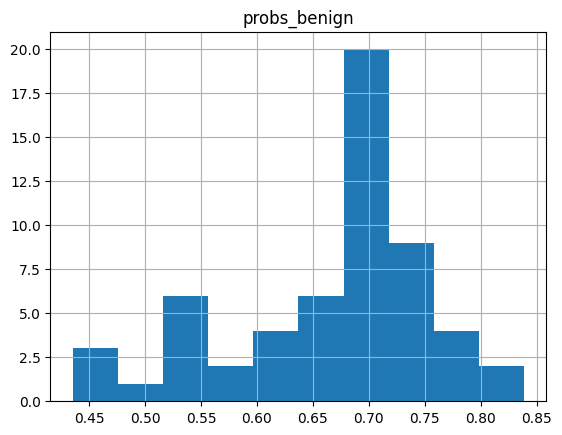

In [21]:
predictions.hist()

array([[<Axes: title={'center': 'calibrated_predictions'}>]], dtype=object)

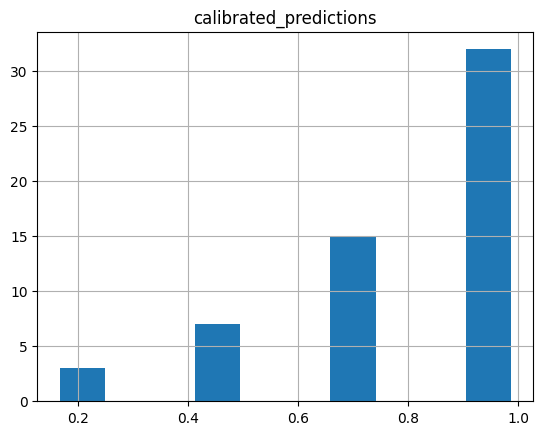

In [22]:
pd.DataFrame(predictions_probs, columns=['calibrated_predictions']).hist()

array([[<Axes: title={'center': 'benign_label'}>]], dtype=object)

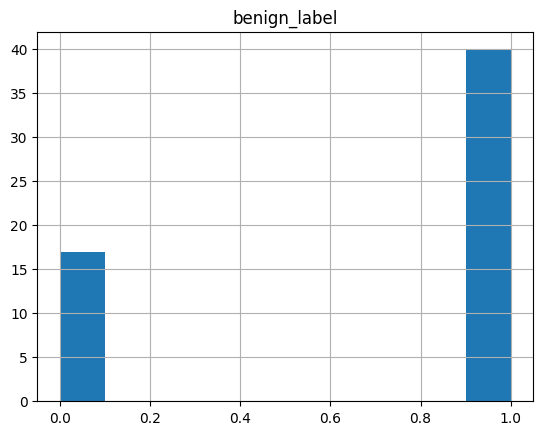

In [23]:
targets.hist()

### Check calibration of test data

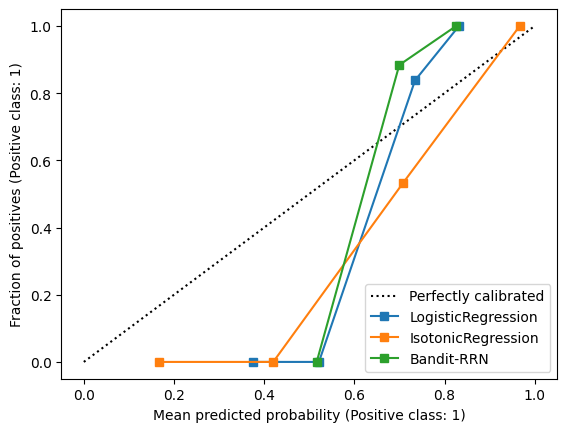

In [24]:
disp = CalibrationDisplay.from_estimator(calibrator, predictions, targets)
disp = CalibrationDisplay.from_predictions(targets, predictions_probs, ax=disp.ax_, name="IsotonicRegression")
disp = CalibrationDisplay.from_predictions(targets, predictions, ax=disp.ax_, name="Bandit-RRN")
plt.show()

# Inspecting the Model

### Global Explain

A global explanation prints the logic learned for each class.  The `quantile` parameter is the percent of the model you would like to be explained.

We represent our features as values scaled between 0 and 1.  Therefore, we intepret the explanations to mean that large values for a particular feature represent `truthiness` of a predicate, while small values represent `falseness` of a predicate.

For example, the following logic for the class `setosa`:

```
A flower is in the setosa class because: 
AND(
    NOT(AND(
            sepal width (cm) >= 0.77405,
            petal length (cm) >= 0.4397)),
    NOT(OR(
            AND(
            sepal width (cm) >= 0.67788,
            petal length (cm) >= 0.20122),
            NOT(sepal width (cm) >= 0.48579))))
```

The `logic` from above is intepreted as:

```
When BOTH of the following are true the class is "setosa":
    1. The flower has a sepal width below the 77th percentile, and has a petal length below the 44th percentile.
    2. The flower has a sepal width below the 68th percentile and a petal length below the 20th percentile; OR the flower has a sepal width above the 49th percentile.
```

#### Print Types

The explanation and printing methods can all be set to use different `print_type` parameters.  Each will produce a different style of explanation that may be used for different end-users.

`logical`: produces a logic statement format such as:

    AND(x1, x2)
    
`logical-natural`: produces a natural language formatted nested tree format, such as:

    the following are TRUE:
        - x1
        - x2
        
`natural`: produces a natural lanugage paragraph indicating the most important logics, to the least important logics, such as:

    Each one of the following must be met.  x1, and x2.


In [36]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=np.array(0.75),
    explain_type='both',
    print_type='logical', 
    explanation_prefix="The patient is in the",
    target_names=['benign'],
    ignore_uninformative=True,
    rounding_precision=4,
    decision_boundary=0.65,
    inverse_transform=mms.inverse_transform
))

The patient is in the benign because: 


OR 
	The concavity error was >= 0.396
	NOT 
		The mean radius was >= 6.981


In [39]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=np.array(0.6),
    explain_type='both',
    print_type='logical-natural', 
    explanation_prefix="The patient is in the",
    target_names=['benign'],
    ignore_uninformative=True,
    rounding_precision=3,
    decision_boundary=0.65,
    inverse_transform=mms.inverse_transform
))

The patient is in the not benign because: 


Any of the following are true: 
	The mean radius was >= 12.307
	The worst concave points was >= 0.055
	It was not true that 
		The concavity error was >= 0.396


### Sample Explain

A sample explanation prints the logic that was used for a particular sample's predition. The `quantile` parameter is the percent of the model you would like to be explained.

In [27]:
print(best_model.explain_samples(
            val_dataset[0]['features'].unsqueeze(0),
            quantile=1.0,
            target_names=['benign'], 
            explain_type='both',
            sample_explanation_prefix="The patient was in the",
            print_type='logical-natural',
            ignore_uninformative=True,
            rounding_precision=3,
            decision_boundary=0.75,
            inverse_transform=mms.inverse_transform,
            min_max_feature_dict={col: {'min': X_train[:, i].min(), 'max': X_train[:, i].max()} for i, col in enumerate(list(data.feature_names))},
            simplify=True,
            exclusions=None
))

0: The patient was in the not benign because: 


All the following are true: 
	The concave points error was less than 0.053 (6th percentile)
	The concavity error was less than 0.279 (36th percentile)
	The mean radius was greater than or equal to 13.65 (1408th percentile)
	The worst concave points was greater than or equal to 0.144 (14th percentile)
	The worst perimeter was greater than or equal to 50.41 (5143th percentile)
	The worst symmetry was greater than or equal to 0.156 (15th percentile)


In [28]:
print(best_model.explain_samples(
    val_dataset[5]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['benign'], 
    explain_type='both',
    sample_explanation_prefix="The patient was",
    print_type='logical-natural',
    ignore_uninformative=True,
    rounding_precision=3,
    decision_boundary=0.75,
    inverse_transform=mms.inverse_transform,
    min_max_feature_dict={col: {'min': data.data[:, i].min(), 'max': data.data[:, i].max()} for i, col in enumerate(list(data.feature_names))},
    simplify=True,
    exclusions=None
))

0: The patient was not benign because: 


All the following are true: 
	The concave points error was less than 0.053 (100th percentile)
	The concavity error was less than 0.168 (42th percentile)
	The mean radius was greater than or equal to 14.899 (37th percentile)
	The worst concave points was greater than or equal to 0.177 (60th percentile)
	The worst perimeter was greater than or equal to 50.41 (0th percentile)
	The worst symmetry was greater than or equal to 0.156 (0th percentile)


In [ ]:
print(best_model.llm_prompt_samples(
    prompt = "You are a superintelligent medial assistant well versed in oncology.  Interpret the following insights about a patient's tumor that is classified as either benign or malignant.  Add medical context and interpret the results as if you were explaining to a patient.  Give less importance to features that are greater than the 0th percentile or less than the 100th percentile.  If a feature is between the 0th and 33rd percentiles it is considered 'low'.  If a feature is between the 34th and 66th percentiles it is considered medium.  If a feature is between the 67th and 100th percentiles it is considered high.",
    x = val_dataset[5]['features'].unsqueeze(0),
    quantile = 1.0,
    target_names = ['benign'],
    explain_type = 'both',
    print_type = 'logical-natural',
    sample_explanation_prefix="The patient's tumor was",
    ignore_uninformative = True,
    rounding_precision = 3,
    inverse_transform=mms.inverse_transform,
    decision_boundary=0.75,
    show_bounds = True,
    simplify = True,
    min_max_feature_dict={col: {'min': data.data[:, i].min(), 'max': data.data[:, i].max()} for i, col in enumerate(list(data.feature_names))},
    max_tokens=1000
))

### Printing the weights

We can inspect the weights the model learned for each logic to see how important they are to the overall prediction.

In [30]:
best_model.print_samples(
    val_dataset[0]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['benign'], 
    explain_type='both',
    print_type='logical',
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: negative of benign
Logic at depth 2: NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave points error was >= 0.053
output: tensor([0.4342, 0.2818, 0.1642])

Logic at depth 1: ['NOT(OR(NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave points error was >= 0.053))']
weights: tensor([-0.0042,  0.1867,  0.0147])
output: 0.942606508731842
required_threshold: 1.0

Logic at depth 2: NOT(the concavity error was >= 0.279), the mean radius was >= 13.65, the worst concave points was >= 0.144
output: tensor([0.5172, 0.3445, 0.3624])

Logic at depth 1: ['OR(NOT(the concavity error was >= 0.279), the mean radius was >= 13.65, the worst concave points was >= 0.144)']
weights: tensor([-0.4345, -0.3231,  0.0273])
output: 0.43146154284477234
required_threshold: 0.4407946467399597

Logic at depth 0: ['AND(NOT(OR(NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave po

In [31]:
best_model.print_samples(
    val_dataset[2]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['benign'], 
    explain_type='both',
    print_type='logical',
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    inverse_transform=mms.inverse_transform,
)

REASONING NETWORK MODEL FOR: negative of benign
Logic at depth 2: NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave points error was >= 0.053
output: tensor([0.1729, 0.2305, 0.1244])

Logic at depth 1: ['NOT(OR(NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave points error was >= 0.053))']
weights: tensor([-0.0042,  0.1867,  0.0147])
output: 0.9516932964324951
required_threshold: 1.0

Logic at depth 2: NOT(the concavity error was >= 0.16), the mean radius was >= 12.696, the worst concave points was >= 0.071
output: tensor([0.2668, 0.3029, 0.0200])

Logic at depth 1: ['OR(NOT(the concavity error was >= 0.16), the mean radius was >= 12.696, the worst concave points was >= 0.071)']
weights: tensor([-0.4345, -0.3231,  0.0273])
output: 0.5443799495697021
required_threshold: 0.5548479557037354

Logic at depth 0: ['AND(NOT(OR(NOT(the worst perimeter was >= 50.41), NOT(the worst symmetry was >= 0.156), the concave po

In [32]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.8),
    explain_type='both',
    print_type='logical', 
    target_names=['benign'],
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    # inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: benign
Logic at depth 2: 
output: tensor([0., 1., 1.])

Logic at depth 2: NOT(the mean radius was >= 0.0), the concavity error was >= 1.0
output: tensor([0.1560, 0.0000, 1.0000])

Logic at depth 1: ['OR(NOT(the mean radius was >= 0.0), the concavity error was >= 1.0)']
weights: tensor([-0.4345, -0.3231,  0.0273])
output: 0.7630000114440918
required_threshold: 0.7609356641769409

Logic at depth 0: ['OR(NOT(the mean radius was >= 0.0), the concavity error was >= 1.0)']
weights: tensor([-0.0412,  0.6643])
output: 0.8009999990463257
required_threshold: 0.800000011920929



In [33]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.6),
    explain_type='both',
    print_type='logical', 
    target_names=['benign'],
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    # inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: negative of benign
Logic at depth 2: 
output: tensor([1., 0., 0.])

Logic at depth 2: NOT(the concavity error was >= 1.0), the mean radius was >= 0.252, the worst concave points was >= 0.188
output: tensor([0.4980, 0.6690, 0.0000])

Logic at depth 1: ['OR(NOT(the concavity error was >= 1.0), the mean radius was >= 0.252, the worst concave points was >= 0.188)']
weights: tensor([-0.4345, -0.3231,  0.0273])
output: 0.45899999141693115
required_threshold: 0.45985114574432373

Logic at depth 0: ['OR(NOT(the concavity error was >= 1.0), the mean radius was >= 0.252, the worst concave points was >= 0.188)']
weights: tensor([-0.0412,  0.6643])
output: 0.5989999771118164
required_threshold: 0.6000000238418579

